In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors

from shapely import wkt
from shapely.geometry import shape
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union

from pathlib import Path
from tqdm import tqdm
from geowrangler.validation import GeometryValidation

/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# custom module
import sys

sys.path.append("../../")  # include parent directory
from src.vector_utils import one_sided_poly_buffer

# Generate coastal buffer

### Set input parameters

In [3]:
DATA_DIR = Path("../../data/")
OUTPUT_FPATH = DATA_DIR / "04-output"

# admin bounds
ADMIN_BOUNDS_PROJECT_ID = "tm-geodata-warehouse"
ADMIN_BOUNDS_BQ_TABLE = "ph_admin_boundary_dec2017.level1_region"

PROJ_CRS = "epsg:3123"
# Buffer settings
BUFFER_M = 30
SIMPLIFY = True

### Load Admin Boundaries

In [4]:
%%time
query = f"""
    SELECT
        ADM1_EN,
        geometry
    FROM
      `{ADMIN_BOUNDS_BQ_TABLE}`
"""
bounds = pd.read_gbq(query, ADMIN_BOUNDS_PROJECT_ID, progress_bar_type="tqdm")
bounds.head()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=F6nU5lr4sIyE6tMEBZ7kf3OnTYAtDu&access_type=offline
Downloading: 100%|██████████|
CPU times: user 12 s, sys: 1.51 s, total: 13.6 s
Wall time: 9min 54s


,ADM1_EN,geometry
0,Region XII,MULTIPOLYGON (((124.241580956 7.26285967200004...
1,Region X,MULTIPOLYGON (((123.5750338820001 8.6334317350...
2,Region VIII,MULTIPOLYGON (((125.060420688 9.96466237200002...
3,Region IV-A,MULTIPOLYGON (((122.7216452990001 13.364847839...
4,Region I,MULTIPOLYGON (((119.8659631480001 15.815394096...


In [5]:
%%time
bounds["geometry"] = gpd.GeoSeries.from_wkt(bounds["geometry"])
bounds = gpd.GeoDataFrame(bounds, geometry="geometry", crs="epsg:4326")
bounds = bounds.to_crs(crs=PROJ_CRS)

CPU times: user 35 s, sys: 532 ms, total: 35.6 s
Wall time: 35.2 s


In [6]:
bounds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ADM1_EN   17 non-null     object  
 1   geometry  17 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 400.0+ bytes


In [7]:
%%time
bounds = bounds.unary_union
type(bounds)

CPU times: user 1min 40s, sys: 2.1 s, total: 1min 42s
Wall time: 1min 42s


shapely.geometry.multipolygon.MultiPolygon

In [8]:
%%time
# need to simplify geometry since it's too high res
if SIMPLIFY:
    bounds = bounds.simplify(tolerance=10)

CPU times: user 50.7 s, sys: 1.27 s, total: 51.9 s
Wall time: 51.9 s


In [9]:
len(bounds.geoms)

3655

In [10]:
%%time
print(f"Generating {BUFFER_M}m buffer")

buffered_bounds = []

for poly in tqdm(bounds.geoms):
    buffered_bound = one_sided_poly_buffer(poly, BUFFER_M)

    # making sure each element in the final list is a polygon, no multipolygons
    if isinstance(buffered_bound, Polygon):
        buffered_bounds.append(buffered_bound)
    elif isinstance(buffered_bound, MultiPolygon):
        buffered_bounds.extend(list(buffered_bound.geoms))
    elif isinstance(buffered_bound, GeometryCollection):
        # if it's a geometry collection, it means the buffer resulted in a very irregular geometry
        # so just keep the original polygon
        buffered_bounds.append(poly)
    else:
        raise ValueError(f"Invalid type {type(buffered_bound)}, please recheck data")

buffered_bounds = MultiPolygon(buffered_bounds)

Generating 30m buffer


100%|██████████| 3655/3655 [00:59<00:00, 61.94it/s] 


CPU times: user 59.3 s, sys: 78.5 ms, total: 59.3 s
Wall time: 59.1 s


In [11]:
%%time

# Convert to GeoSeries and explode polygons
buffered_bounds = gpd.GeoSeries(buffered_bounds, crs=PROJ_CRS)
buffered_bounds = buffered_bounds.explode(ignore_index=True)
buffered_bounds = buffered_bounds.to_crs(crs="epsg:4326")
buffered_bounds.head()

CPU times: user 7.75 s, sys: 0 ns, total: 7.75 s
Wall time: 7.74 s


0    POLYGON ((119.20565 4.66970, 119.20567 4.66995...
1    POLYGON ((119.03071 4.70988, 119.03056 4.71081...
2    POLYGON ((119.14804 4.72133, 119.14824 4.72007...
3    POLYGON ((119.23621 4.72625, 119.23447 4.72620...
4    POLYGON ((118.31951 6.08667, 118.32024 6.08628...
dtype: geometry

In [12]:
# Convert to GeoDataFrame
buffered_bounds = gpd.GeoDataFrame(buffered_bounds).reset_index()
buffered_bounds = buffered_bounds.rename(columns={0: "geometry", "index": "uid"})
buffered_bounds.head()

,uid,geometry
0,0,"POLYGON ((119.20565 4.66970, 119.20567 4.66995..."
1,1,"POLYGON ((119.03071 4.70988, 119.03056 4.71081..."
2,2,"POLYGON ((119.14804 4.72133, 119.14824 4.72007..."
3,3,"POLYGON ((119.23621 4.72625, 119.23447 4.72620..."
4,4,"POLYGON ((118.31951 6.08667, 118.32024 6.08628..."


In [13]:
%%time
# Fixing Invalid Geometries
# defined validators here since crs_bounds validator doesn't work
validators = ("null", "self_intersecting", "orientation", "area")
buffered_bounds = GeometryValidation(
    buffered_bounds, validators=validators, add_validation_columns=False
).validate_all()
buffered_bounds.head()

CPU times: user 24.3 s, sys: 742 ms, total: 25.1 s
Wall time: 25.1 s


,uid,geometry
0,0,"POLYGON ((119.20565 4.66970, 119.20750 4.66894..."
1,1,"POLYGON ((119.03071 4.70988, 119.03140 4.70875..."
2,2,"POLYGON ((119.14804 4.72133, 119.14743 4.72209..."
3,3,"POLYGON ((119.23621 4.72625, 119.23685 4.72612..."
4,4,"POLYGON ((118.31951 6.08667, 118.31838 6.08666..."


/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


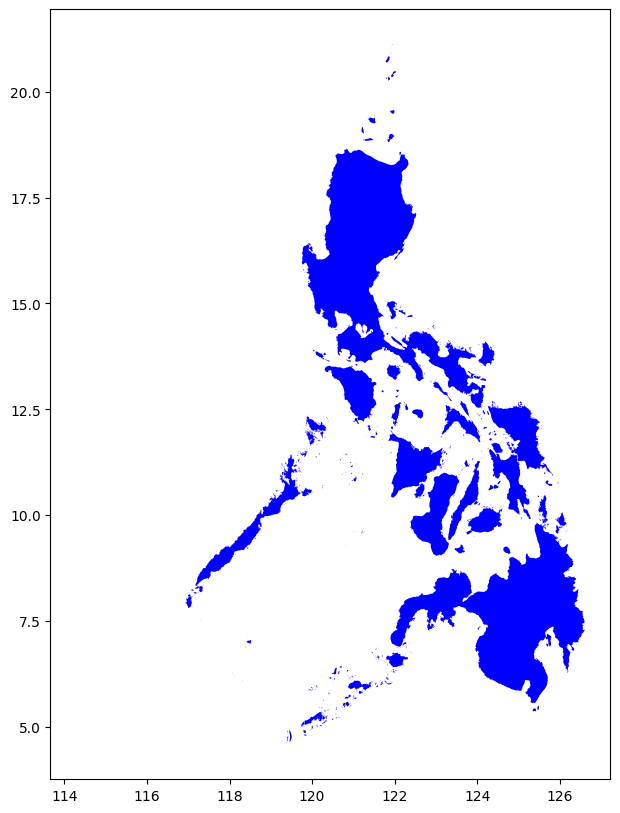

CPU times: user 7.26 s, sys: 553 ms, total: 7.81 s
Wall time: 7.18 s


In [14]:
%%time
orig = gpd.GeoSeries(MultiPolygon([Polygon(b) for b in bounds.geoms]), crs=PROJ_CRS)
orig = orig.to_crs("epsg:4326")

fig, ax = plt.subplots(figsize=(10, 10))
orig.plot(ax=ax, color="blue", label="orig")
buffered_bounds.plot(ax=ax, color="red", label="one-sided buffer")
plt.show()

In [15]:
buffered_bounds.to_file(OUTPUT_FPATH / "ph_coasts_30m.gpkg", driver="GPKG")

/home/abbymoreno/miniconda3/envs/lacuna-fund2/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Keep for visualization

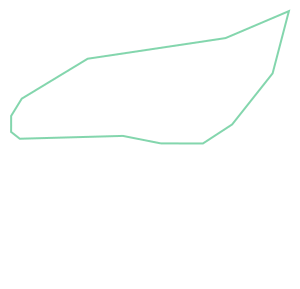

In [9]:
bounds.geoms[3].boundary

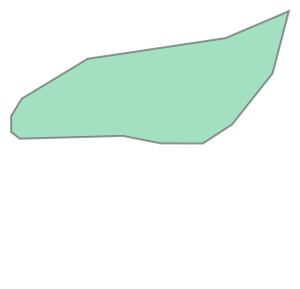

In [10]:
bounds.geoms[3]

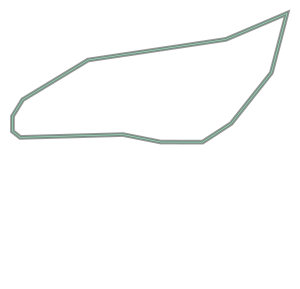

In [11]:
# simple buffer example
buffer_m = 5
single_sided_buffer = bounds.geoms[3].boundary.buffer(-buffer_m, single_sided=True)
single_sided_buffer

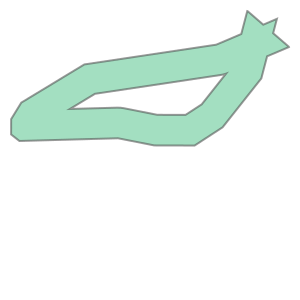

In [12]:
# simple buffer example
buffer_m = 60
single_sided_buffer = bounds.geoms[3].boundary.buffer(-buffer_m, single_sided=True)
single_sided_buffer

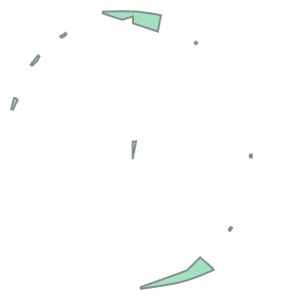

In [16]:
poly = bounds.geoms[3]
buffer_m = 3_000
bound = poly.boundary
buffered_bound = bound.buffer(-buffer_m / 2, single_sided=True)

buffered_bound

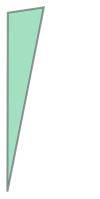

In [17]:
# take the intersection to remove the outward spikes from a single sided buffer
buffered_bound = buffered_bound.intersection(poly)

buffered_bound

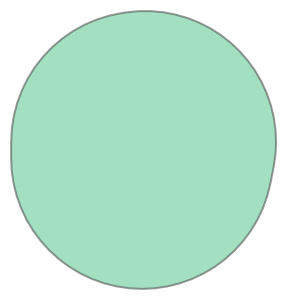

In [18]:
# buffer it again to fill in inward spikes
buffered_bound = buffered_bound.buffer(buffer_m / 2)

buffered_bound

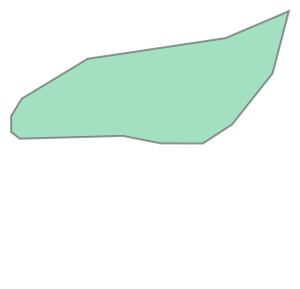

In [19]:
# take intersection to remove outward spikes again
buffered_bound = buffered_bound.intersection(poly)

buffered_bound